# Lab CMBLenses

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `/global/u2/j/jaimerz/PhD/MicroCanonicalHMC.jl/examples`


In [2]:
using Revise, Adapt, CMBLensing, CMBLensingInferenceTestProblem, CUDA,
    JLD2, LaTeXStrings, LinearAlgebra, 
    MCMCChains, MCMCDiagnosticTools, MicroCanonicalHMC, MuseInference, MuseInference, Plots, 
    ProgressMeter, Random, Statistics, Zygote

In [3]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [4]:
Nside = 512
T = Float64;
masking = true
global_parameters = true
t = 0.15 #nothing
precond_path = string("../chains/pixel_preconditioners/pp_nside_512_t_", t)
file_path = 
println("Nside: ", Nside)
println("Masking: ", masking)
println("Global_parameters: ", global_parameters)
println("Precond: ", precond_path)

Nside: 512
Masking: true
Global_parameters: true
Precond: ../chains/pixel_preconditioners/pp_nside_512_t_0.15


In [5]:
prob = load_cmb_lensing_problem(;storage=CuArray, T, Nside,
    masking=masking, global_parameters=global_parameters);
d = length(prob.Ωstart)
to_vec, from_vec = CMBLensingInferenceTestProblem.to_from_vec(prob.Ωstart);
println("Built problem")

KeyError: KeyError: key "usage_request" not found

Built problem


In [6]:
#Precond
prob.Λmass.diag.θ.r *= 5.85
prob.Λmass.diag.θ.Aϕ *= 112.09

if t == nothing
    precond = one(simulate(Diagonal(one(LenseBasis(diag(prob.Λmass))))));
else
    precond = load(precond_path, "dist_mat_precond")
    precond = adapt(CuArray, precond)
    precond = from_vec(precond);
end

786434-element Field-(f°,ϕ°,θ)-Tuple{BaseField{QUMap, ProjLambert{Float64, CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}, Float64, CuArray{Float64, 3, CUDA.Mem.DeviceBuffer}}, BaseField{Map, ProjLambert{Float64, CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}, Float64, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

# MCHMC

In [9]:
#Target
target = CMBLensingTarget(prob);

In [39]:
#Sampler
TEV = 0.005
spl = MCHMC(1000, TEV; adaptive=true, init_eps=30, init_L=500, sigma=precond);

In [40]:
fol_name=string("/pscratch/sd/j/jaimerz/chains/512/MCHMC/CMBLensing",
    "_cosmo_", global_parameters,
    "_masking_", masking,
    "_precond_", t,
    "_Nside_", Nside,
    "_TEV_", TEV)

if isdir(fol_name)
    fol_files = readdir(fol_name)
    println("Found existing file ", fol_name)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("chain", file)])
        last_n = parse(Int, last_chain[end])
        last_chain = load(string(fol_name, "/", last_chain), "samples")
        init_params = last_chain[:, end]
        println("Restarting chain")
    else
        println("Starting new chain")
        last_n = 0
        init_params = prob.Ωstart
    end
else
    mkdir(fol_name)
    println(string("Created new folder ", fol_name))
    last_n = 0
end

file_name = string(fol_name, "/chain_", last_n+1)

Found existing file /pscratch/sd/j/jaimerz/chains/512/MCHMC/CMBLensing_cosmo_true_masking_true_precond_0.15_Nside_512_TEV_0.005
Restarting chain


"/pscratch/sd/j/jaimerz/chains/512/MCHMC/CMBLensing_cosmo_true_masking_true_precond_0.15_Nside_512_TEV_0.005/chain_2"

In [ ]:
prob.ncalls[] = 0
samples_mchmc = Sample(spl, target, 60_000, dialog=false, progress=true,
                       init_params=init_params, thinning=20, file_name=file_name);
ncalls_mchmc = prob.ncalls[]

MCHMC:   9%|████                                        |  ETA: 1:03:45
  ϵ:     133.50448703025853
  dE/d:  1.4859904203251887e-6

In [ ]:
samples_mchmc = adapt(Array, samples_mchmc);

In [ ]:
chain_mchmc = Chains(
    permutedims(reduce(hcat, [[exp.(sample[end÷2-2:end÷2-1]); sample[end-3:end]] for sample in eachcol(samples_mchmc) if all(isfinite.(sample))])),
    [:r, :Aϕ, :p_logr, :p_logAϕ, :dE, :logpdf],
);

In [ ]:
ess_mchmc = MCMCDiagnosticTools.ess(chain_mchmc)[[:r,:Aϕ],:ess]

In [ ]:
ess_per_call_mchmc = ess_mchmc / 10000 #ncalls_mchmc

In [ ]:
size(samples_mchmc)

## Plot

In [ ]:
plot(chain_mchmc[:r], label=L"r", xlabel="step")
plot!(chain_mchmc[:Aϕ], label=L"A_\phi")

In [ ]:
plot(chain_mchmc[:p_logr], label=L"\Pi(\log \, r)", xlabel="step")
plot!(chain_mchmc[:p_logAϕ], label=L"\Pi(\log \, A_\phi)")

In [ ]:
plot(chain_mchmc[:dE]/d, label=L"\mathrm{Energy}/d", xlabel="step")

In [ ]:
vars = var(samples_mchmc, dims=2)[1:d]
_vars = var(samples_mchmc, dims=2)[d+1:2*d]

In [ ]:
k = round(maximum(vars)/minimum(vars), digits=2)
_k = round(maximum(_vars)/minimum(_vars), digits=2)

In [ ]:
plot(_vars, title="Diag(cov) - Masked", label=string("Latent space --> K = ", _k))
plot!(vars, label=string("Parameter space --> K = ", k))

In [ ]:
histogram2d(chain_mchmc[:r], chain_mchmc[:Aϕ], bins=(40, 20), show_empty_bins=true,
    normalize=:pdf, color=:plasma)
title!("Masked - NSIDE=64")
ylabel!("Aϕ")
xlabel!("r")

In [ ]:
plot(
    histogram(chain_mchmc[:r], xlabel=L"r", label=nothing, lw=1),
    histogram(chain_mchmc[:Aϕ], xlabel=L"A_\phi", label=nothing, lw=1),
    size = (700,300)
)

# HMC

In [7]:
Ω = prob.Ωstart
samples_hmc = []
rng = Xoshiro(1)
prob.ncalls[] = 0
ϵ=0.0001
iterations = 100
@showprogress for i=1:iterations
    Ω, = state = hmc_step(rng, prob, Ω, prob.Λmass; symp_kwargs=[(N=25, ϵ=ϵ)], progress=false, always_accept=(i<10))
    push!(samples_hmc, adapt(Array, state))
end
ncalls_hmc = prob.ncalls[]

Progress:   9%|███▋                                     |  ETA: 0:24:05

KeyError: KeyError: key "usage_request" not found

Progress: 100%|█████████████████████████████████████████| Time: 0:21:53


28000

In [90]:
a = Diagonal(DerivBasis(precond)) .* Diagonal(prob.Λmass)
a.X

LoadError: Can't broadcast fields in QUFourier and EBFourier bases.

In [93]:
Diagonal(DerivBasis(precond))

394754×394754 Diagonal{ComplexF64, FieldTuple{NamedTuple{(:f°, :ϕ°, :θ), Tuple{BaseField{QUFourier, ProjLambert{Float64, CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}, ComplexF64, CuArray{ComplexF64, 3, CUDA.Mem.DeviceBuffer}}, BaseField{Fourier, ProjLambert{Float64, CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}, ComplexF64, CuArray{ComplexF64, 2, CUDA.Mem.DeviceBuffer}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}}, CMBLensing.BasisProd{Tuple{QUFourier, Fourier, CMBLensing.Basis}}, ComplexF64}}:
 1.48573e5+0.0im           ⋅          …      ⋅          ⋅          ⋅    
           ⋅      -40157.8-246.408im         ⋅          ⋅          ⋅    
           ⋅               ⋅                 ⋅          ⋅          ⋅    
           ⋅               ⋅                 ⋅          ⋅          ⋅    
           ⋅               ⋅                 ⋅          ⋅    

In [56]:
prob.Λmass

394754×394754 Diagonal{Float64, FieldTuple{NamedTuple{(:f°, :ϕ°, :θ), Tuple{BaseField{EBFourier, ProjLambert{Float64, CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}, Float64, CuArray{Float64, 3, CUDA.Mem.DeviceBuffer}}, BaseField{Fourier, ProjLambert{Float64, CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}, Float64, CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}}, CMBLensing.BasisProd{Tuple{EBFourier, Fourier, CMBLensing.Basis}}, Float64}}:
 0.0   ⋅           ⋅          ⋅         ⋅        …   ⋅           ⋅       ⋅ 
  ⋅   0.00889269   ⋅          ⋅         ⋅            ⋅           ⋅       ⋅ 
  ⋅    ⋅          0.0931309   ⋅         ⋅            ⋅           ⋅       ⋅ 
  ⋅    ⋅           ⋅         0.310971   ⋅            ⋅           ⋅       ⋅ 
  ⋅    ⋅           ⋅          ⋅        0.677319      ⋅           ⋅ 

In [98]:
precond[1]

524288-element 512×512-pixel 3.0′-resolution LambertQUMap{CuArray{Float64, 3, CUDA.Mem.DeviceBuffer}}:
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 ⋮
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15
 0.15

In [8]:
_samples_hmc = zeros(iterations, 3*Nside^2+2)
for i in 1:1_000
    _samples_hmc[i, :]  = samples_hmc[i][1][:]
end
_samples_hmc

1000×786434 Matrix{Float64}:
 -0.015681    -0.0173449    -0.0148593  …  0.000174972  -1.61438  -0.00261663
 -0.0253007   -0.0180763    -0.0392046     0.000174949  -1.62312  -0.00613823
 -0.0275826   -0.00374992   -0.0313478     0.000174938  -1.61852  -0.00877195
 -0.0196419   -0.000320647  -0.0422871     0.000174938  -1.63125  -0.0125952
 -0.00221867  -0.00293803   -0.0279999     0.000174939  -1.63704  -0.0161814
 -0.00961548   0.0121543    -0.0230611  …  0.000174962  -1.64912  -0.0194642
 -0.0168168   -0.0035671    -0.0266278     0.000174904  -1.65271  -0.023502
 -0.0131332    0.00865764   -0.0409878     0.000174946  -1.65357  -0.0276567
 -0.0166491    0.0220909    -0.030823      0.000174933  -1.66592  -0.0298266
 -0.0078206    0.00618503   -0.0259637     0.000174949  -1.67451  -0.0347371
 -0.011491     0.00281035   -0.0367814  …  0.000174982  -1.68288  -0.040499
 -0.00509254  -0.0160825    -0.0358251     0.000174966  -1.68813  -0.046289
 -0.00806399  -0.0349572    -0.0314214     0.00

In [24]:
fol_name=string("/pscratch/sd/j/jaimerz/chains/512/HMC/CMBLensing",
    "_cosmo_", global_parameters,
    "_masking_", masking,
    "_Nside_", Nside,
    "_ϵ_", ϵ)

if isdir(fol_name)
    fol_files = readdir(fol_name)
    println("Found existing file ", fol_name)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("chain", file)])
        last_n = parse(Int, last_chain[end])
        last_chain = load(string(fol_name, "/", last_chain), "samples")
        init_params = last_chain[:, end]
        println("Restarting chain")
    else
        println("Starting new chain")
        last_n = 0
        init_params = prob.Ωstart
    end
else
    mkdir(fol_name)
    println(string("Created new folder ", fol_name))
    last_n = 0
end

file_name = string(fol_name, "/chain_", last_n+1)

@save file_name samples_hmc

KeyError: KeyError: key "usage_request" not found

KeyError: KeyError: key "usage_request" not found

In [10]:
#samples_hmc = load("../chains/HMC/CMBLensing_masked_Nnside_64_ϵ_0.25", "_samples_hmc")

In [11]:
chain_hmc = Chains(
    permutedims(reduce(hcat, [exp.(sample[1].θ) for sample in samples_hmc])),
    [:r, :Aϕ],
);

## Plot

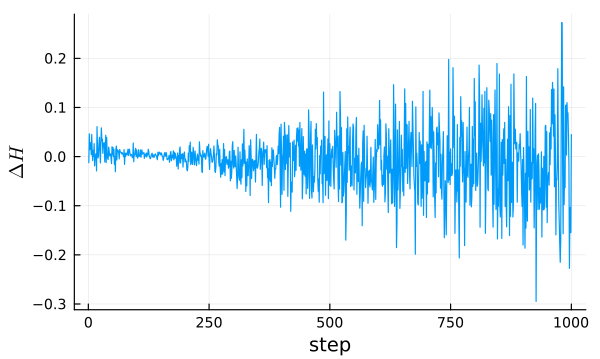

In [17]:
plot(getindex.(samples_hmc, 2), label=nothing, xlabel="step", ylabel=L"\Delta H")     

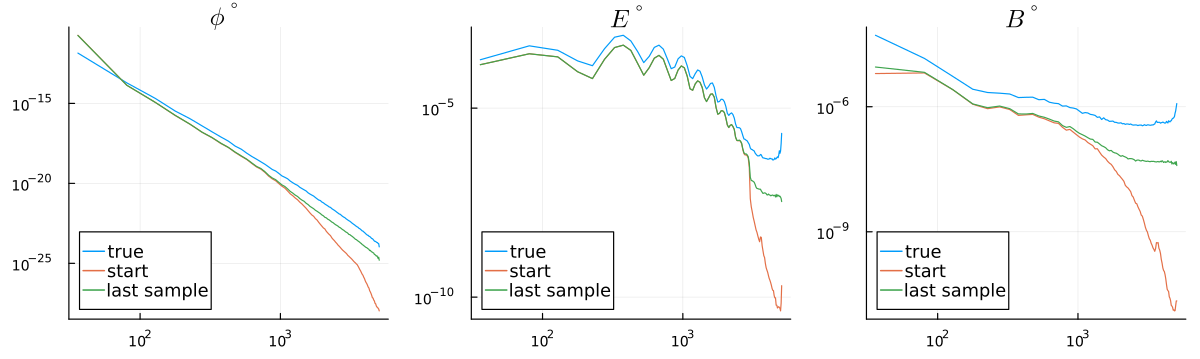

GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27
GKS: glyph missing from current font: 27


In [18]:
ps = map([(:ϕ°,:I,L"L",L"\phi^\circ"), (:f°,:E,"L\ell",L"E^\circ"), (:f°,:B,L"\ell",L"B^\circ")]) do (k1, k2, xlabel, title)
    plot(get_Cℓ(prob.Ωtrue[k1][k2]); label="true", xlabel, title)
    plot!(get_Cℓ(prob.Ωstart[k1][k2]); label="start", xlabel, title)
    plot!(get_Cℓ(samples_hmc[end][1][k1][k2]); label="last sample", xlabel, title)
end
plot(ps..., layout=(1,3), xscale=:log10, yscale=:log10, size=(1000,300), legend=:bottomleft)
     


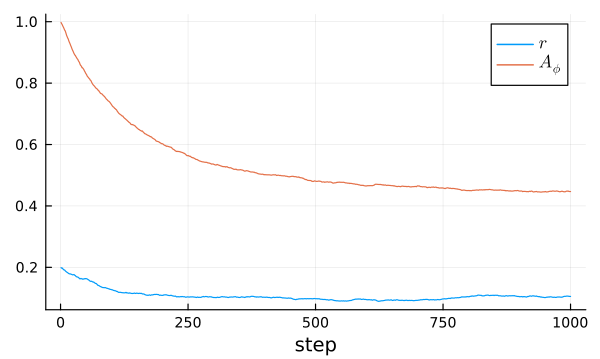

KeyError: KeyError: key "usage_request" not found

In [22]:
plot([exp(Ω.θ.r) for (Ω,) in samples_hmc], label=L"r", xlabel="step")
plot!([exp(Ω.θ.Aϕ) for (Ω,) in samples_hmc], label=L"A_\phi")     


In [15]:
ess_hmc = MCMCDiagnosticTools.ess(chain_hmc)[[:r,:Aϕ],:ess]

2-element Vector{Float64}:
 3.6462779171017545
 2.3887121084747984

In [16]:
ess_per_call_hmc = ess_hmc ./ ncalls_hmc

2-element Vector{Float64}:
 0.00013022421132506267
 8.53111467312428e-5

# MUSE

In [39]:
using CMBLensing.ComponentArrays, MuseInference.FiniteDifferences

In [40]:
muse_prob = CMBLensingMuseProblem(
    prob.ds, 
    MAP_joint_kwargs = (minsteps=3, nsteps=15, αtol=1e-2, gradtol=3e-5, progress=false, history_keys=(:logpdf, :ΔΩ°_norm)),
);

In [41]:
# small hack to allow getting MUSE covariance in terms of transformed θ
CMBLensingMuseInferenceExt = Base.get_extension(CMBLensing,:CMBLensingMuseInferenceExt)
CMBLensingMuseInferenceExt.mergeθ(prob::CMBLensingMuseInferenceExt.CMBLensingMuseProblem, θ) = exp.(θ)

In [42]:
# z₀ = zero(FieldTuple(MuseInference.select(NamedTuple(prob.Ωstart), (:f°, :ϕ°))))
# H_pre = Diagonal(FieldTuple(MuseInference.select(NamedTuple(prob.Λmass.diag), (:f°, :ϕ°))))
# H_pre_map = let H_pre=H_pre, z₀=z₀
#     MuseInference.LinearMap{eltype(z₀)}(length(z₀), issymmetric=true) do z
#         f, = promote(z, z₀)
#         LenseBasis(H_pre \ f)[:]
#     end
# end
# implicit_diff_cg_kwargs = (maxiter=1500,Pl=MuseInference.InverseMap(H_pre_map));

In [ ]:
z₀ = zero(MuseInference.sample_x_z(muse_prob, Xoshiro(0), prob.Ωstart.θ).z);
result = MuseResult()
nsims = 200
rng = Xoshiro(0)

prob.ncalls[] = 0
MuseInference.muse!(result,  muse_prob, prob.Ωstart.θ; nsims, rng, z₀, maxsteps=2, θ_rtol=0, progress=true, save_MAPs=false)
MuseInference.get_J!(result, muse_prob; nsims,   rng, z₀, progress=true)
MuseInference.get_H!(result, muse_prob; nsims=4, rng, z₀, progress=true, step=std(result.gs)/100, fdm=central_fdm(2,1,adapt=0))
ncalls_muse = prob.ncalls[];

In [ ]:
chain_muse = Chains(permutedims(rand(result.dist,5_000)), [:logr, :logAϕ]);

In [ ]:
@save string("/pscratch/sd/j/jaimerz/chains/MUSE/CMBLensing_masking_", masking, "_Nside_", Nside) chain_muse

In [ ]:
"/pscratch/sd/j/jaimerz/chains/MUSE/"

In [ ]:
#chain_muse = load("../chains/MUSE/CMBLensing_masked_Nnside_64", "chain_muse")

In [ ]:
ess_per_call_muse = nsims / ncalls_muse

## Plot

In [ ]:
plot(
    map(result.history[1:1:end]) do h
        p = plot()
        for x in h.ẑ_history_sims
            plot!(first.(x), yscale=:log10)
        end
        plot!(first.(h.ẑ_history_dat), yscale=:log10, c=:black)
        p
    end...,
    size = (1000,500),
    xticks = 0:2:15,
    # ylim = (1e-7, 1e-3)
)

In [ ]:
plot(
    map(result.history[1:1:end]) do h
        p = plot()
        for x in h.ẑ_history_sims
            plot!(last.(x), yscale=:log10)
        end
        plot!(last.(h.ẑ_history_dat), yscale=:log10, c=:black)
        p
    end...,
    size = (1000,500),
    xticks = 0:2:15,
    ylim = (1e-7, 1e-3)
)

In [ ]:
plot(
    plot(getindex.([getindex.(result.history, :θ); [result.θ]], :r), m="."),
    plot(getindex.([getindex.(result.history, :θ); [result.θ]], :Aϕ), m=".")
)

# Compare

In [ ]:
ess_per_call_muse ./ minimum(ess_per_call_hmc)

In [ ]:
ess_per_call_muse ./ minimum(ess_per_call_mchmc)

In [ ]:
ess_per_call_mchmc

In [ ]:
ess_per_call_hmc

In [ ]:
ess_per_call_muse

In [ ]:
which_ess = minimum # can be: first (r), last (Aphi), or minimum
bar(
    ["HMC" "MCHMC" "MUSE"],
    which_ess.([[ess_per_call_hmc] [ess_per_call_mchmc] [ess_per_call_muse]]),
    ylabel = "eff. samples / ∇logP eval", legend=false)

In [ ]:
p = plot(label=L"r", xlabel="step (scaled consistently for both)")
for k in [:r, :Aϕ]
    plot!(log.(chain_hmc[k][1:length(chain_mchmc)÷25]), c=1, label=(k==:r ? "HMC" : nothing))
    plot!(log.(chain_mchmc[k][1:25:end]), c=2, label=(k==:r ? "MCHMC" : nothing))
end
p

In [ ]:
plot(
    begin
        histogram(log.(chain_hmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:r]), normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MCHMC")
        histogram!(chain_muse[:logr], normalize=:pdf, alpha=0.5, bins=range(-4,0,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.r], c=4, lw=3, label="Truth")
    end, 
    begin
        histogram(log.(chain_hmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="HMC")
        histogram!(log.(chain_mchmc[:Aϕ]), normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MCHMC")
        histogram!(chain_muse[:logAϕ], normalize=:pdf, alpha=0.5, bins=range(-0.6,0.6,length=40), label="MUSE")
        vline!([prob.Ωtrue.θ.Aϕ], c=4, lw=3, label="Truth")
    end, 
    size = (700, 300)
)